## Dependency

In [0]:
!pip install google_images_download

## Imports

In [0]:
from google_images_download import google_images_download
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Resize
import requests
import matplotlib.pyplot as plt
from pathlib import Path
from urllib.request import urlretrieve
from PIL import Image

## Helper Functions

In [0]:
#https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests#16696317
def download_file(url, file):
    local_filename = file
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return local_filename


#http://www.stealthcopter.com/blog/2009/09/python-making-multi-depth-directories/
import os
def mkdirnotex(filename):
	folder=os.path.dirname(filename)
	if not os.path.exists(folder):
		os.makedirs(folder)

## Dataset

In [0]:
class GoogleImageOnFlyDataset(Dataset):
    def _download_urls(self, arguments):
        response = google_images_download.googleimagesdownload()
        urls = response.download(arguments)[0]
        for k,v in urls.items():
            if len(v) > 0:
                continue
            arguments["keywords"] = k
            urls[k] = self._download_urls(arguments)[k]
        return urls

    def __init__(self, keywords: [str, list], limit=100, folder=Path("giof"), transform=None):
        if type(keywords) == list: keywords = ','.join(keywords)

        arguments = {
            "keywords": keywords,
            "limit":limit,
            "print_urls":False,
            "no_download": True,
            "silent_mode": True
            }
        
        urls = self._download_urls(arguments)
        self.folder = folder

        self.X = []
        self.y = []
        self.classes = list(urls.keys())
        
        for key,value in urls.items():
            self.X += value
            self.y += [self.classes.index(key)]*len(value)
        self.size = len(self.y)
        self.downloaded = {}
        self.transform = transform
    
    def _download_image(self,url,dest):
        mkdirnotex(dest)
        if os.path.isfile(dest): return
        download_file(url, dest)

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        assert 0 <= index <= self.size
        
        url = self.X[index]
        target = self.y[index]
        image = self.downloaded.get(url, False)
        if image:
            img = Image.open(image)
            if self.transform: img = self.transform(img)
            return img, target

        ext = url.split('.')[-1]
        dest = self.folder/self.classes[target]/f"{index}"

        try:
            self._download_image(url, dest)
        except:
            return self[np.random.choice(self.size)]
        self.downloaded[url] = dest
        return self[index]

## Usage

In [135]:
_transforms = transforms.Compose([transforms.Resize((300,300)),
                                 transforms.CenterCrop((250,250)),
                                 transforms.ToTensor(),
                                 ])
keywords = "Polar bears,baloons,Beaches" # list of classes
giof= GoogleImageOnFlyDataset(keywords,transform=_transforms)

In [0]:
dl = DataLoader(giof,batch_size=4,shuffle=True, num_workers=4)

In [0]:
sample = next(iter(dl))

#https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t
grid_img = torchvision.utils.make_grid(sample[0], nrow=5)

['baloons', 'Polar bears', 'baloons', 'Beaches']


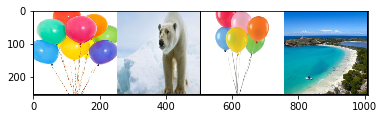

In [138]:
print([giof.classes[i] for i in sample[1]])
plt.imshow(grid_img.permute(1, 2, 0))